In [236]:
# Libraries and testing data

import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import sklearn.metrics as metrics

DIM = 2
COLORS = ['red', 'blue']
K = None
KC = None

# 2-D mean of ones
M1 = np.ones((DIM,))
# 2-D mean of threes
M2 = 3 * np.ones((DIM,))
# 2-D covariance of 0.3
C1 = np.diag(0.3 * np.ones((DIM,)))
# 2-D covariance of 0.2
C2 = np.diag(0.2 * np.ones((DIM,)))

def generate_gaussian(m, c, num):
    return np.random.multivariate_normal(m, c, num)

def plot_data_with_labels(x, y):
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        plt.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])
    plt.show()
    
def plot_data_with_line(x, y, w, b):
    x1= np.arange(0,6);
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        plt.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    print(slope)
    print(intercept)
    print(x1 * slope + intercept)
    plt.plot(x1, x1 * slope + intercept, 'k-')
    plt.show()



NUM = 50

In [237]:
def fitSVM(x, y): 
    global K
    global KC
    NUM = x.shape[0]
    
    Y = np.reshape(y, (NUM, 1))
    Ym = np.matmul(Y,Y.T)
    # we'll solve the dual
    # obtain the kernel
    K = np.zeros((NUM,NUM))
    for i in range(NUM):
        counter = 0
        for j in range(NUM):
            Xi = np.array(x[i])
            Xj = np.array(x[j])
            K[i][j] = np.matmul(Xi, Xj.T)
            counter = counter+ 1

    K = np.multiply(K, Ym)
    P = matrix(K)
    q = matrix(-np.ones((NUM, 1)))
    G = matrix(-np.eye(NUM))
    h = matrix(np.zeros(NUM))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

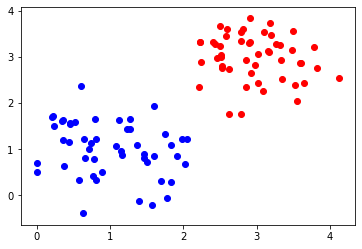

In [238]:

# generate 50 points from gaussian 1
x1 = generate_gaussian(M1, C1, NUM)
# labels
y1 = np.ones((x1.shape[0],))
# generate 50 points from gaussian 2
x2 = generate_gaussian(M2, C2, NUM)
y2 = -np.ones((x2.shape[0],))
# join
x = np.concatenate((x1, x2), axis = 0)
y = np.concatenate((y1, y2), axis = 0)
plot_data_with_labels(x, y)

# fit svm classifier
alphas = fitSVM(x, y)

# get weights
w = np.sum(alphas * y[:, None] * x, axis = 0)
# get bias
cond = (alphas > 1e-4).reshape(-1)
b = y[cond] - np.dot(x[cond], w)
b = np.mean(b)

-1.4986243681052858
5.002516875988324
[ 5.00251688  3.50389251  2.00526814  0.50664377 -0.9919806  -2.49060496]


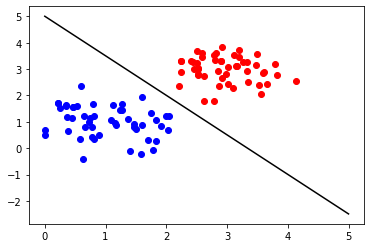

In [239]:
plot_data_with_line(x,y,w,b)

In [240]:
sigma = .5

def fitNonLinear(x, y): 
    global K
    global KC
    NUM = x.shape[0]
    DIM = x.shape[1]
    
    Y = np.reshape(y, (NUM, 1))
    Ym = np.matmul(Y,Y.T)
    # we'll solve the dual
    # obtain the kernel
    K = metrics.pairwise.rbf_kernel(x, x, sigma)
    K = np.multiply(K, Ym)
    P = matrix(K)
    q = matrix(-np.ones((NUM, 1)))
    G = matrix(-np.eye(NUM))
    h = matrix(np.zeros(NUM))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

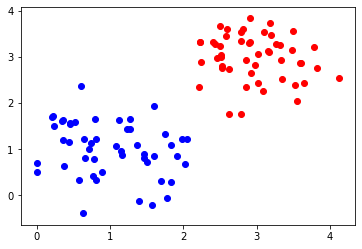

In [241]:
plot_data_with_labels(x, y)

# fit svm classifier
alphas = fitNonLinear(x, y)

cond = (alphas > 1e-4)
alpha_sv = alphas[cond]
n_sv = len(alpha_sv)
xCond = cond.reshape(-1)
x_sv = x[xCond, :]
y_sv = y[xCond]
K_sv = K[xCond,xCond]

b = np.mean(y_sv - K_sv*(np.multiply(alpha_sv, y_sv)))


In [242]:
n1 = 100
n2 = 100

x1plot = np.linspace(0,6, n1)
x2plot = np.linspace(0,6,n2)

[X1,X2] = np.meshgrid(x1plot,x2plot)

x1m = np.reshape(X1,n1*n2,1)
x2m = np.reshape(X2,n1*n2,1)
Xm = np.array([x1m, x2m]).T

ym = np.zeros((n1*n2,1))

for j in range(n1*n2):
    x_p = Xm[j]
    K_pred = metrics.pairwise.rbf_kernel([x_p], x_sv, sigma)
    ym[j] = np.sign(np.sum(np.multiply(np.multiply(alpha_sv,y_sv), K_pred)) + b)
    
yplot = np.reshape(ym, (n1, n2))

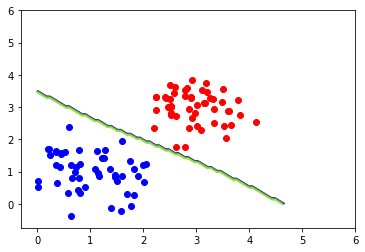

In [243]:
def plot_data_with_contour(x, y, x1P, x2P, yP):
    x1= np.arange(0,6);
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        plt.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])

    plt.contour(x1P, x2P, yP)
    plt.show()
    
plot_data_with_contour(x,y,x1plot, x2plot, yplot)

In [244]:
sigma = 3

def fitLS(x, y): 
    global K
    global KC
    NUM = x.shape[0]
    DIM = x.shape[1]
    
    Y = np.reshape(y, (NUM, 1))
    Ym = np.matmul(Y,Y.T)
    # we'll solve the dual
    # obtain the kernel
    K = metrics.pairwise.rbf_kernel(x, x, sigma)

    Omega = np.multiply(K, Ym)
    onev = np.ones((NUM, 1))
    gamma = 1
    
    yforA = np.reshape(y, (NUM, 1))
    
    A11 = np.zeros(1).reshape((1,1))
    A12 = yforA.T
    A21 = yforA
    A22 = Omega + np.eye(NUM)/gamma
    
    A1 = np.hstack((A11, A12))
    A2 = np.hstack((A21, A22))

    A =  np.vstack((A1, A2))
    
    B = np.vstack((A11, onev))
    
    sol = np.linalg.solve(A, B)
    b= sol[0]
    alpha=sol[1:]
    
    return {
        'b': b,
        'alphas': alpha
    }

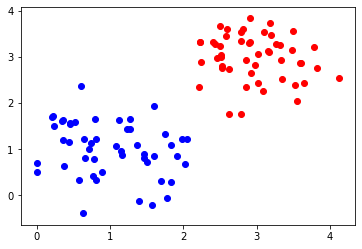

In [245]:
plot_data_with_labels(x, y)

# fit svm classifier
alphas = fitLS(x, y)

In [246]:
n1 = 100
n2 = 100

x1plot = np.linspace(0,6, n1)
x2plot = np.linspace(0,6,n2)

[X1,X2] = np.meshgrid(x1plot,x2plot)

x1m = np.reshape(X1,n1*n2,1)
x2m = np.reshape(X2,n1*n2,1)
Xm = np.array([x1m, x2m]).T

ym = np.zeros((n1*n2,1))

for j in range(n1*n2):
    x_p = Xm[j]
    K_pred = metrics.pairwise.rbf_kernel([x_p], x, sigma)
    ym[j] = np.sign(np.sum(np.multiply(np.multiply(alphas['alphas'],y), K_pred)) + alphas['b'])
    
yplot = np.reshape(ym, (n1, n2))

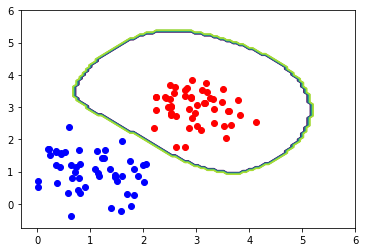

In [247]:
def plot_data_with_contour(x, y, x1P, x2P, yP):
    x1= np.arange(0,6);
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        plt.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])

    plt.contour(x1P, x2P, yP)
    plt.show()
    
plot_data_with_contour(x,y,x1plot, x2plot, yplot)

In [248]:
sigma = 1

def fitLS_SVR(x, y): 
    global K
    global KC
    NUM = x.shape[0]
    DIM = x.shape[1]
    
    Y = np.reshape(y, (NUM, 1))
    Ym = np.matmul(Y,Y.T)

    # we'll solve the dual
    # obtain the kernel
    K = metrics.pairwise.rbf_kernel(x, x, sigma)

    Omega = np.multiply(K, Ym)
    onev = np.ones((NUM, 1))
    gamma = 1
    
    yforA = np.reshape(y, (NUM, 1))

    A11 = np.zeros(1).reshape((1,1))
    A12 = onev.T
    A21 = onev
    A22 = Omega + np.eye(NUM)/gamma
    
    A1 = np.hstack((A11, A12))
    A2 = np.hstack((A21, A22))

    A =  np.vstack((A1, A2))
    
    B = np.vstack((A11, yforA))
    
    sol = np.linalg.solve(A, B)
    b= sol[0]
    alpha=sol[1:]
    
    return {
        'b': b,
        'alphas': alpha
    }

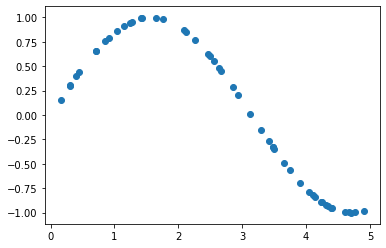

In [249]:
x = np.sort(5 * np.random.rand(NUM, 1), axis=0)
y = np.sin(x).ravel()

y = y.reshape((NUM, 1))

def plot_data(x, y):
    plt.scatter(x, y)
    plt.show()
plot_data(x,y)

# fit svm classifier
alphas = fitLS_SVR(x, y)

In [251]:
b = alphas['b']
alphas = alphas['alphas']
cond = (alphas > 1e-4)
alpha_sv = alphas[cond]
n_sv = len(alpha_sv)
xCond = cond.reshape(-1)
x_sv = x[xCond, :]
y_sv = y[xCond]
K_sv = K[xCond,xCond]

In [252]:
n1 = 100


x1plot = np.linspace(0,5, n1)
x1plot = x1plot.reshape((n1, 1))
ym = np.zeros((n1,1))

for j in range(n1):
    x_p = x1plot[j]
    K_pred = metrics.pairwise.rbf_kernel([x_p], x_sv, sigma)
    ym[j] = np.sum(np.multiply(alpha_sv, K_pred)) + b
    
#yplot = np.reshape(ym, (n1, n2))

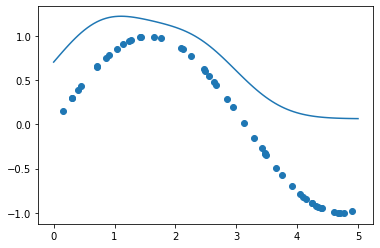

In [253]:
def plot_data_with_predict(x, y, x1P, ym):
    plt.scatter(x, y)
    plt.plot(x1plot, ym)
    #plt.contour(x1P, x2P, yP)
    plt.show()
    
plot_data_with_predict(x,y,x1plot, ym)

C:\Users\Tejon\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


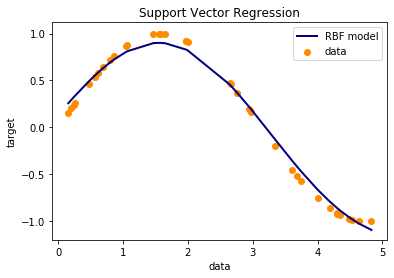

In [233]:
#SVR from sklearn

from sklearn.svm import SVR

X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

x = X


svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(x, y).predict(x)
y_lin = svr_lin.fit(x, y).predict(x)
y_poly = svr_poly.fit(x, y).predict(x)

lw = 2
plt.scatter(x, y, color='darkorange', label='data')
plt.plot(x, y_rbf, color='navy', lw=lw, label='RBF model')
#plt.plot(x, y_lin, color='c', lw=lw, label='Linear model')
#plt.plot(x, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()